In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from keras.applications.vgg16 import preprocess_input

import os
import cv2
from os import walk
import glob as gb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
SEED = 1000
IMG_SIZE = 100
BATCH_SIZE = 24

TRAIN_DIR = 'D:/ML/envs/gpu/Datasets/Gender_classification/gender_rev2/train'
VALID_DIR = 'D:/ML/envs/gpu/Datasets/Gender_classification/gender_rev2/valid'
TEST_DIR = 'D:/ML/envs/gpu/Datasets/Gender_classification/gender_rev2/test'

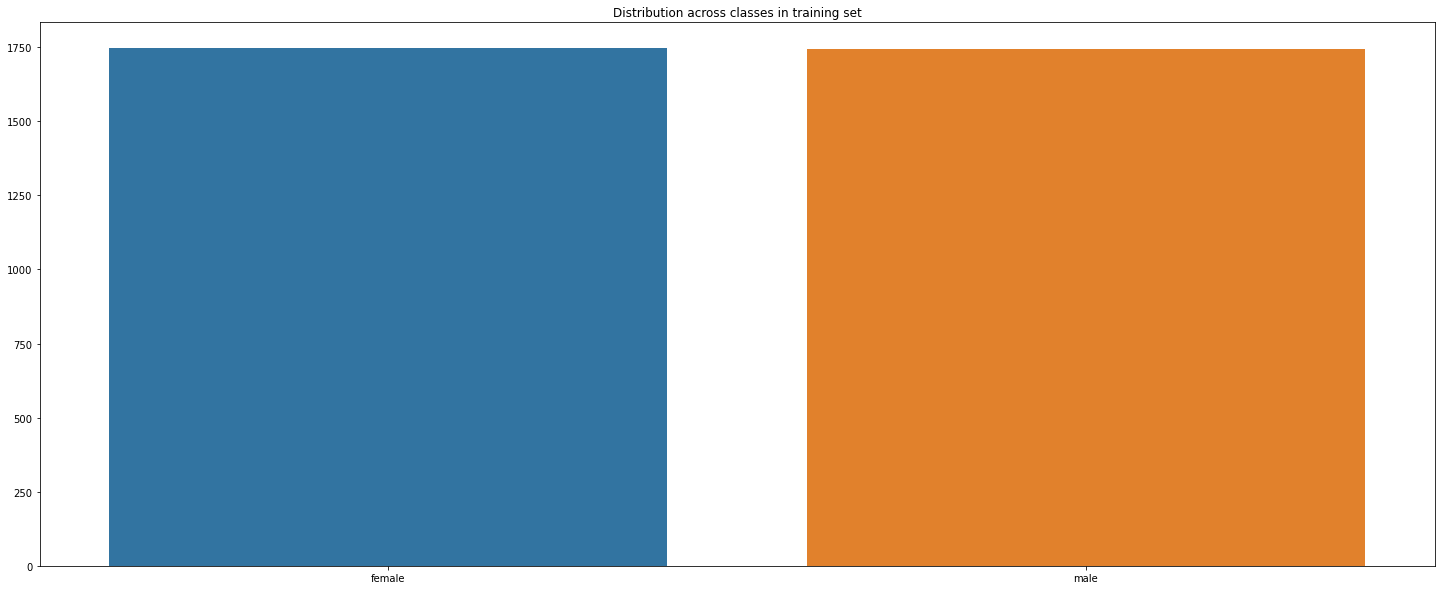

Total Train Examples = 3491


In [3]:
class_names = []
class_count = []
TRAIN_EXAMPLES = 0
for folder in  os.listdir(TRAIN_DIR) : 
    files = gb.glob(pathname= str( TRAIN_DIR + '//' + folder + '/*'))
    class_names.append(folder)
    class_count.append(len(files))
    TRAIN_EXAMPLES += len(files)

plt.figure(figsize=(25,10))    
sns.barplot(x = class_names, y=class_count).set_title("Distribution across classes in training set")
plt.show()

print(f'Total Train Examples = {TRAIN_EXAMPLES}')

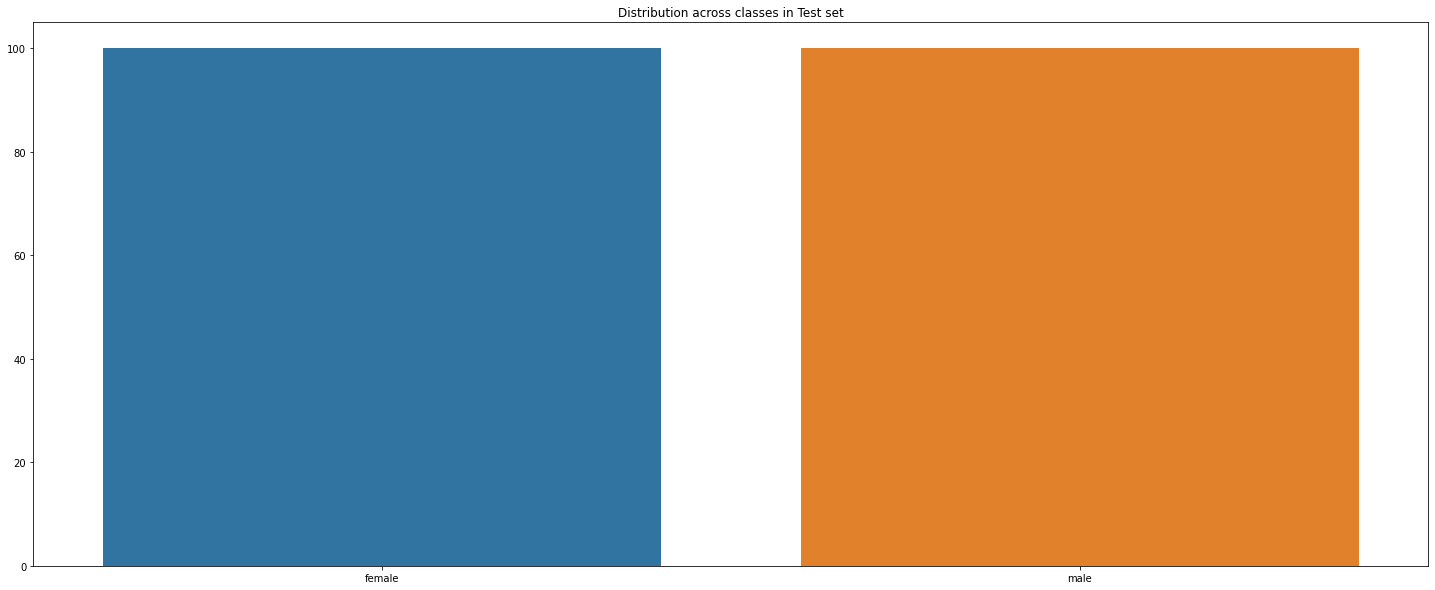

Total Test Examples = 200


In [4]:
class_names = []
class_count = []
Test_EXAMPLES = 0
for folder in  os.listdir(TEST_DIR) : 
    files = gb.glob(pathname= str( TEST_DIR + '//' + folder + '/*'))
    class_names.append(folder)
    class_count.append(len(files))
    Test_EXAMPLES += len(files)

plt.figure(figsize=(25,10))     
sns.barplot(x = class_names, y=class_count).set_title("Distribution across classes in Test set")
plt.show()

print(f'Total Test Examples = {Test_EXAMPLES}')

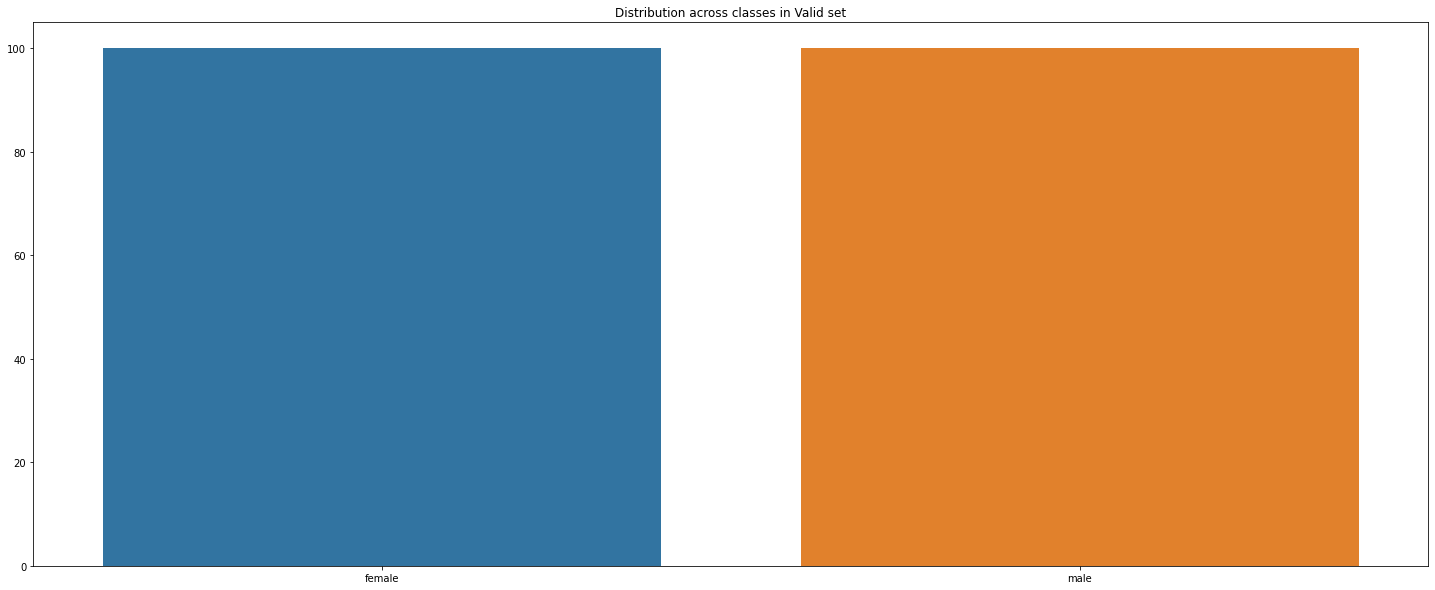

Total Validation Examples = 200


In [5]:
class_names = []
class_count = []
VALIDATION_EXAMPLES = 0
for folder in  os.listdir(VALID_DIR) : 
    files = gb.glob(pathname= str( VALID_DIR + '//' + folder + '/*'))
    class_names.append(folder)
    class_count.append(len(files))
    VALIDATION_EXAMPLES += len(files)

plt.figure(figsize=(25,10))     
sns.barplot(x = class_names, y=class_count).set_title("Distribution across classes in Valid set")
plt.show()

print(f'Total Validation Examples = {VALIDATION_EXAMPLES}')

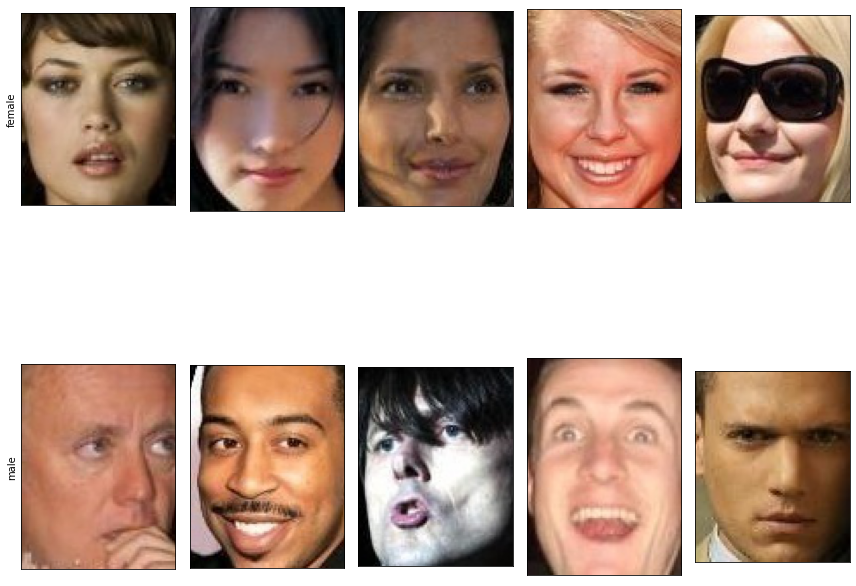

In [6]:
# diaplay 5 images from each class
plt.figure(figsize=(12,12))
i=0
for c in os.listdir(TRAIN_DIR):  
    path = os.path.join(TRAIN_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.cvtColor(cv2.imread(os.path.join(path,img)), cv2.COLOR_BGR2RGB) 
        plt.subplot(2,5,i+1)
        plt.imshow(img_array)
        if i%5 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%5 == 0:
            break

plt.tight_layout()        
plt.show() 

In [7]:
train_gen = ImageDataGenerator(
    
    featurewise_center=False,
    
    samplewise_center=False,
    
    featurewise_std_normalization=False,
    
    samplewise_std_normalization=False,
    
    zca_whitening=False,
    
    zca_epsilon=1e-06,
    
    rotation_range=30,
    
    width_shift_range=0.2,
    
    height_shift_range=0.2,
    
    shear_range=0.2,
    
    zoom_range=0.3,
    
    channel_shift_range=0.,
    
    fill_mode='nearest',
    
    cval=0.,
    
    horizontal_flip=True,
    
    vertical_flip=False,
    
    rescale=None,
    
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    
    data_format=None,
    
    
    validation_split=0.0,
    
    dtype=tf.float32,
)

test_gen = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.resnet50.preprocess_input, 
    dtype=tf.float32
)

In [8]:
train_batch = train_gen.flow_from_directory(
    directory = TRAIN_DIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    seed = SEED
)

Found 3491 images belonging to 2 classes.


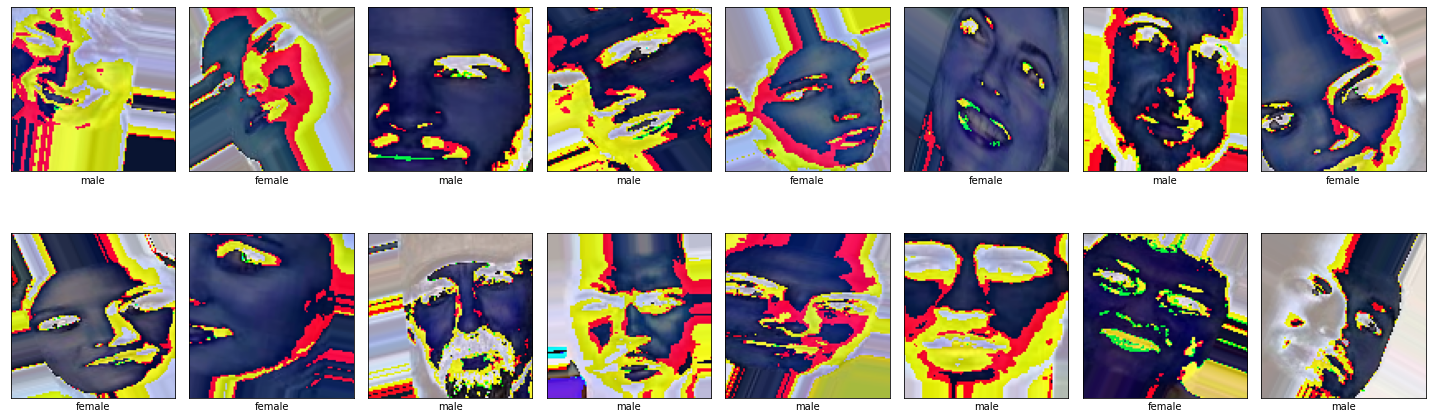

In [9]:

imgs, labels = next(train_batch)
i = 0
plt.figure(figsize=(20,7))
for img, label in zip(imgs, labels):
    plt.subplot(2,8,i+1)
    plt.imshow(img.astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[label.astype('int32')])
    i+=1
    if i == 16:
        break
        
plt.tight_layout()
plt.show()

In [10]:
valid_batch = train_gen.flow_from_directory(
    directory = VALID_DIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    seed = SEED
)

Found 200 images belonging to 2 classes.


In [11]:
test_batch = test_gen.flow_from_directory(
    directory = TEST_DIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = None,
    seed = SEED
)

Found 200 images belonging to 2 classes.


In [12]:
def identity_block(X, filters):
    f1, f2, f3 = filters
    X_copy = X
    
    
    X = layers.Conv2D(filters=f1, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)
    
    
    X = layers.Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), padding='same')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X) 
    
   
    X = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    
   
    X = layers.Add()([X, X_copy])
    X = layers.Activation('relu')(X)
    
    return X

In [13]:
def conv_blocks(X, filters, s=2):
    f1, f2, f3 = filters
    X_copy = X
    
    
    X = layers.Conv2D(filters=f1, kernel_size=(1,1), strides=(s,s), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)
    
    
    X = layers.Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1), padding='same')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X) 
    
    
    X = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    
    
    X_copy = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=(s,s), padding='valid')(X_copy)
    X_copy = layers.BatchNormalization(axis=3)(X_copy)
    
    
    X = layers.Add()([X, X_copy])
    X = layers.Activation('relu')(X)
    
    return X

In [14]:
def ResNet50():
    X_input = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    X = layers.ZeroPadding2D((3,3))(X_input)
    
   
    X = layers.Conv2D(64, (7,7), strides=(2,2))(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X) 
    X = layers.MaxPooling2D((3,3), strides=(2,2))(X)
    
   
    X = conv_blocks(X, filters=[64,64,256], s=1)
    X = identity_block(X, filters=[64,64,256])
    X = identity_block(X, filters=[64,64,256])
    
   
    X = conv_blocks(X, filters=[128,128,512], s=2)
    X = identity_block(X, filters=[128,128,512])
    X = identity_block(X, filters=[128,128,512])
    X = identity_block(X, filters=[128,128,512])
    
    
    X = conv_blocks(X, filters=[256,256,1024], s=2)
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    X = identity_block(X, filters=[256,256,1024])
    
    
    X = conv_blocks(X, filters=[512,512,2048], s=2)
    X = identity_block(X, filters=[512,512,2048])
    X = identity_block(X, filters=[512,512,2048])
    
    
    X = layers.AveragePooling2D((2,2))(X)
    X = layers.Flatten()(X)
    X = layers.Dense(2, activation='sigmoid', kernel_initializer='he_normal')(X)
    
    model = keras.Model(inputs=X_input, outputs=X, name='ResNet50')
    
    return model

In [15]:
model = ResNet50()
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 50, 64)  256         ['conv2d[0][0]']          

In [16]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 40:
        lr *= 0.5e-3
    elif epoch > 30:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

In [17]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=lr_schedule(0)), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

Learning rate:  0.001


D:\ML\envs\gpu\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
h = model.fit(train_batch, 
              epochs=50,
              steps_per_epoch = TRAIN_EXAMPLES // BATCH_SIZE,
              validation_data = valid_batch,
              validation_steps = VALIDATION_EXAMPLES // BATCH_SIZE,
              callbacks=lr_scheduler,
              verbose=2
             )

Learning rate:  0.001
Epoch 1/50
145/145 - 30s - loss: 1.1052 - accuracy: 0.5345 - val_loss: 0.7086 - val_accuracy: 0.5677 - lr: 0.0010 - 30s/epoch - 205ms/step
Learning rate:  0.001
Epoch 2/50
145/145 - 20s - loss: 0.6314 - accuracy: 0.6484 - val_loss: 0.6127 - val_accuracy: 0.7083 - lr: 0.0010 - 20s/epoch - 135ms/step
Learning rate:  0.001
Epoch 3/50
145/145 - 20s - loss: 0.5197 - accuracy: 0.7439 - val_loss: 1.3963 - val_accuracy: 0.6198 - lr: 0.0010 - 20s/epoch - 135ms/step
Learning rate:  0.001
Epoch 4/50
145/145 - 20s - loss: 0.4207 - accuracy: 0.8004 - val_loss: 0.6363 - val_accuracy: 0.7969 - lr: 0.0010 - 20s/epoch - 136ms/step
Learning rate:  0.001
Epoch 5/50
145/145 - 20s - loss: 0.3563 - accuracy: 0.8414 - val_loss: 0.3441 - val_accuracy: 0.8698 - lr: 0.0010 - 20s/epoch - 135ms/step
Learning rate:  0.001
Epoch 6/50
145/145 - 20s - loss: 0.3039 - accuracy: 0.8705 - val_loss: 0.4652 - val_accuracy: 0.8125 - lr: 0.0010 - 20s/epoch - 135ms/step
Learning rate:  0.001
Epoch 7/50
1

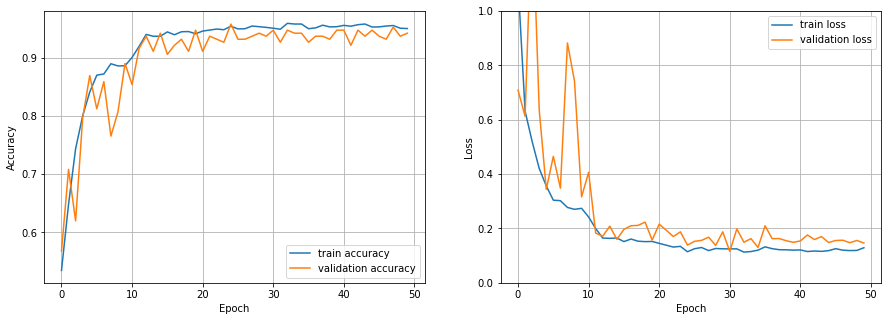

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],  label='train accuracy')
plt.plot(h.history['val_accuracy'],  label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'],  label='train loss')
plt.plot(h.history['val_loss'],  label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.ylim([0,1])
plt.legend(loc='upper right')

plt.show()

# --------CNN Architecture-------

In [20]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
train_male_dir = os.path.join('D:/ML/envs/gpu/Datasets/Gender_classification/gender_rev2/train/male/')


train_female_dir = os.path.join('D:/ML/envs/gpu/Datasets/Gender_classification/gender_rev2/train/female/')


validation_male_dir = os.path.join('D:/ML/envs/gpu/Datasets/Gender_classification/gender_rev2/valid/male/')


validation_female_dir = os.path.join('D:/ML/envs/gpu/Datasets/Gender_classification/gender_rev2/valid/female/')

In [22]:
train_m_names = os.listdir(train_male_dir)
print(train_m_names[:10])

train_f_names = os.listdir(train_female_dir)
print(train_f_names[:10])

validation_m_names = os.listdir(validation_male_dir)
print(validation_m_names[:10])

validation_f_names = os.listdir(validation_female_dir)
print(validation_f_names[:10])

['0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg', '0006.jpg', '0007.jpg', '0008.jpg', '0009.jpg', '0010.jpg']
['0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg', '0006.jpg', '0007.jpg', '0008.jpg', '0009.jpg', '0010.jpg']
['001.jpg', '002.jpg', '003.jpg', '004.jpg', '005.jpg', '006.jpg', '007.jpg', '008.jpg', '009.jpg', '010.jpg']
['001.jpg', '002.jpg', '003.jpg', '004.jpg', '005.jpg', '006.jpg', '007.jpg', '008.jpg', '009.jpg', '010.jpg']


In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
nrows = 4
ncols = 4
pic_index = 0

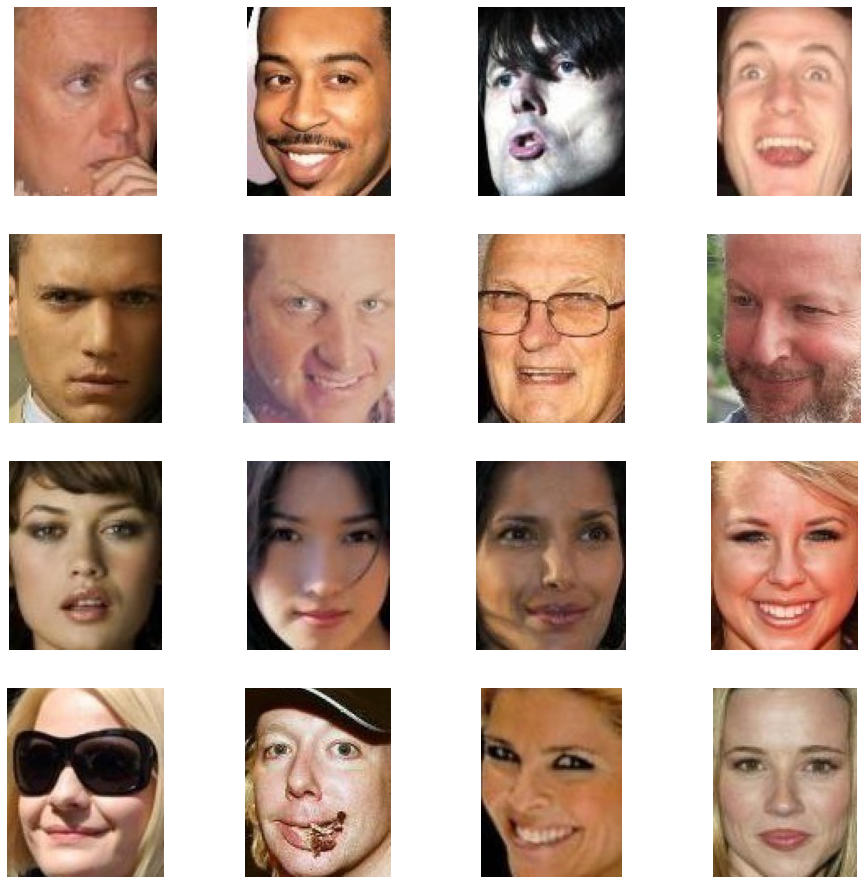

In [24]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_m_pix = [os.path.join(train_male_dir, fname) 
                for fname in train_m_names[pic_index-8:pic_index]]
next_f_pix = [os.path.join(train_female_dir, fname) 
                for fname in train_f_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_m_pix+next_f_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [25]:
model_cnn = tf.keras.models.Sequential([
   
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    
    tf.keras.layers.Dense(2, activation='sigmoid')
])

In [26]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_54 (Conv2D)          (None, 47, 47, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_55 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 10, 64)       0

In [27]:
model_cnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=  'adam',
    metrics=['accuracy'])

In [28]:
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)


train_generator = train_datagen.flow_from_directory(
        'D:/ML/envs/gpu/Datasets/Gender_classification/gender_rev2/train/',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=True)


validation_generator = validation_datagen.flow_from_directory(
        'D:/ML/envs/gpu/Datasets/Gender_classification/gender_rev2/valid/',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='sparse')


Found 3491 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [29]:
history_cnn = model_cnn.fit(
      train_generator,
      steps_per_epoch=32,  
      epochs=50,
      verbose=1,
      validation_data = validation_generator
      )

Epoch 1/50
32/32 [==============================] - 2s 29ms/step - loss: 0.6948 - accuracy: 0.5000 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 2/50
32/32 [==============================] - 1s 21ms/step - loss: 0.6931 - accuracy: 0.5234 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 3/50
32/32 [==============================] - 1s 21ms/step - loss: 0.6921 - accuracy: 0.5026 - val_loss: 0.6916 - val_accuracy: 0.5000
Epoch 4/50
32/32 [==============================] - 1s 34ms/step - loss: 0.6886 - accuracy: 0.5245 - val_loss: 0.6373 - val_accuracy: 0.6450
Epoch 5/50
32/32 [==============================] - 1s 21ms/step - loss: 0.6307 - accuracy: 0.6758 - val_loss: 0.4956 - val_accuracy: 0.7600
Epoch 6/50
32/32 [==============================] - 1s 23ms/step - loss: 0.5668 - accuracy: 0.7113 - val_loss: 0.6272 - val_accuracy: 0.7700
Epoch 7/50
32/32 [==============================] - 1s 20ms/step - loss: 0.5765 - accuracy: 0.7383 - val_loss: 0.4859 - val_accuracy: 0.8150
Epoch 8/50
32

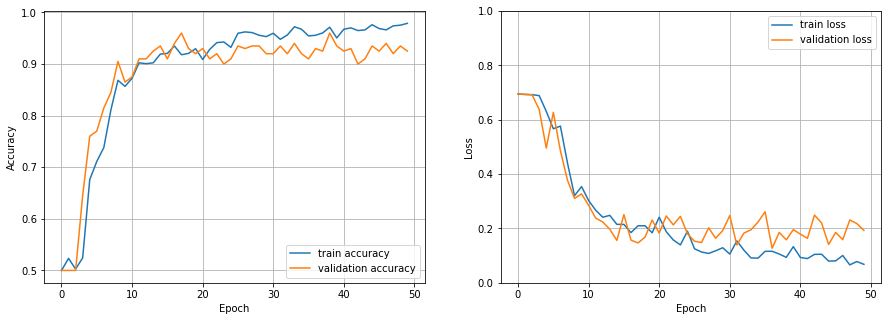

In [30]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'],  label='train accuracy')
plt.plot(history_cnn.history['val_accuracy'],  label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'],  label='train loss')
plt.plot(history_cnn.history['val_loss'],  label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.ylim([0,1])
plt.legend(loc='upper right')

plt.show()

# -------VGG16----------

In [67]:
from glob import glob
image_files = glob(training_dir + '/*/*')
valid_image_files = glob(validation_dir + '/*/*')

In [68]:
folders = glob(training_dir + '/*')
num_classes = len(folders)
print ('Total Classes = ' + str(num_classes))

Total Classes = 2


In [69]:
from keras.models import Model
from keras.layers import Flatten, Dense
from tensorflow.keras.applications.vgg16 import VGG16


IMAGE_SIZE = [IMG_SIZE, IMG_SIZE] 


vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False) 


for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)

x = Dense(num_classes, activation = 'sigmoid')(x)  

model = Model(inputs = vgg.input, outputs = x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [70]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 185, 185, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 185, 185, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 185, 185, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 92, 92, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 92, 92, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 92, 92, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 46, 46, 128)       0   

In [71]:
training_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    shear_range=0.2, 
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    preprocessing_function=preprocess_input)

validation_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input)

training_generator = training_datagen.flow_from_directory(
    training_dir, 
    target_size = IMAGE_SIZE, 
    batch_size = BATCH_SIZE, 
    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    target_size = IMAGE_SIZE, 
    batch_size = BATCH_SIZE, 
    class_mode = 'categorical')

Found 3491 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [72]:
training_generator.class_indices

{'female': 0, 'male': 1}

In [73]:
training_images = 3491
validation_images = 200

history = model.fit_generator(training_generator,
                   steps_per_epoch = 24,
                   epochs = 50,
                   validation_data = validation_generator)
                   
                             

C:\Users\JAMILI~1\AppData\Local\Temp/ipykernel_17092/4127595918.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(training_generator,


Epoch 1/50
24/24 [==============================] - 6s 237ms/step - loss: 0.5252 - accuracy: 0.7318 - val_loss: 0.3724 - val_accuracy: 0.8400
Epoch 2/50
24/24 [==============================] - 6s 260ms/step - loss: 0.3694 - accuracy: 0.8420 - val_loss: 0.2803 - val_accuracy: 0.8750
Epoch 3/50
24/24 [==============================] - 6s 257ms/step - loss: 0.3043 - accuracy: 0.8733 - val_loss: 0.3606 - val_accuracy: 0.8450
Epoch 4/50
24/24 [==============================] - 7s 281ms/step - loss: 0.2697 - accuracy: 0.8889 - val_loss: 0.2669 - val_accuracy: 0.8950
Epoch 5/50
24/24 [==============================] - 6s 232ms/step - loss: 0.2839 - accuracy: 0.8819 - val_loss: 0.2521 - val_accuracy: 0.8950
Epoch 6/50
24/24 [==============================] - 6s 242ms/step - loss: 0.2450 - accuracy: 0.9062 - val_loss: 0.2171 - val_accuracy: 0.9150
Epoch 7/50
24/24 [==============================] - 6s 237ms/step - loss: 0.2103 - accuracy: 0.9271 - val_loss: 0.1853 - val_accuracy: 0.8950
Epoch 

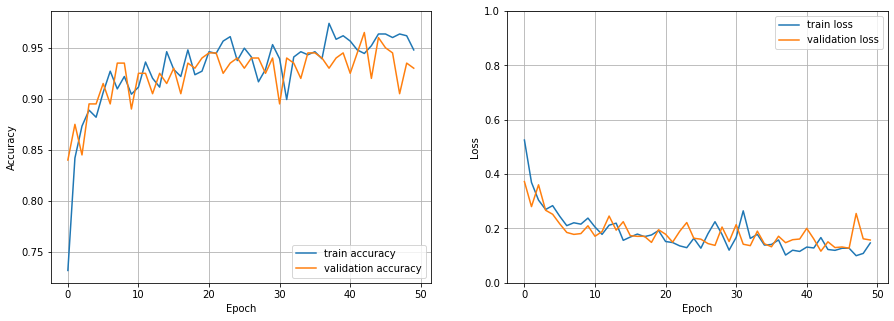

In [84]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],  label='train accuracy')
plt.plot(history.history['val_accuracy'],  label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'],  label='train loss')
plt.plot(history.history['val_loss'],  label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.ylim([0,1])
plt.legend(loc='upper right')

plt.show()

# -------Filter Visualization (VGG16)-------

In [85]:
model = vgg

for i in range(len(model.layers)):
    layer = model.layers[i]

    if 'conv' not in layer.name:
        continue

    print(i, layer.name, layer.output.shape)

1 block1_conv1 (None, 128, 128, 64)
2 block1_conv2 (None, 128, 128, 64)
4 block2_conv1 (None, 64, 64, 128)
5 block2_conv2 (None, 64, 64, 128)
7 block3_conv1 (None, 32, 32, 256)
8 block3_conv2 (None, 32, 32, 256)
9 block3_conv3 (None, 32, 32, 256)
11 block4_conv1 (None, 16, 16, 512)
12 block4_conv2 (None, 16, 16, 512)
13 block4_conv3 (None, 16, 16, 512)
15 block5_conv1 (None, 8, 8, 512)
16 block5_conv2 (None, 8, 8, 512)
17 block5_conv3 (None, 8, 8, 512)


In [86]:
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [87]:
img = tf.keras.utils.load_img('D:/ML/envs/gpu/Datasets/Gender_classification/gender_rev2/train/male/0019.jpg', target_size=(128, 128))

In [88]:
img = tf.keras.utils.img_to_array(img)
img = np.expand_dims(img, axis=0)

In [89]:
img = preprocess_input(img)

In [90]:
feature_maps = model.predict(img)

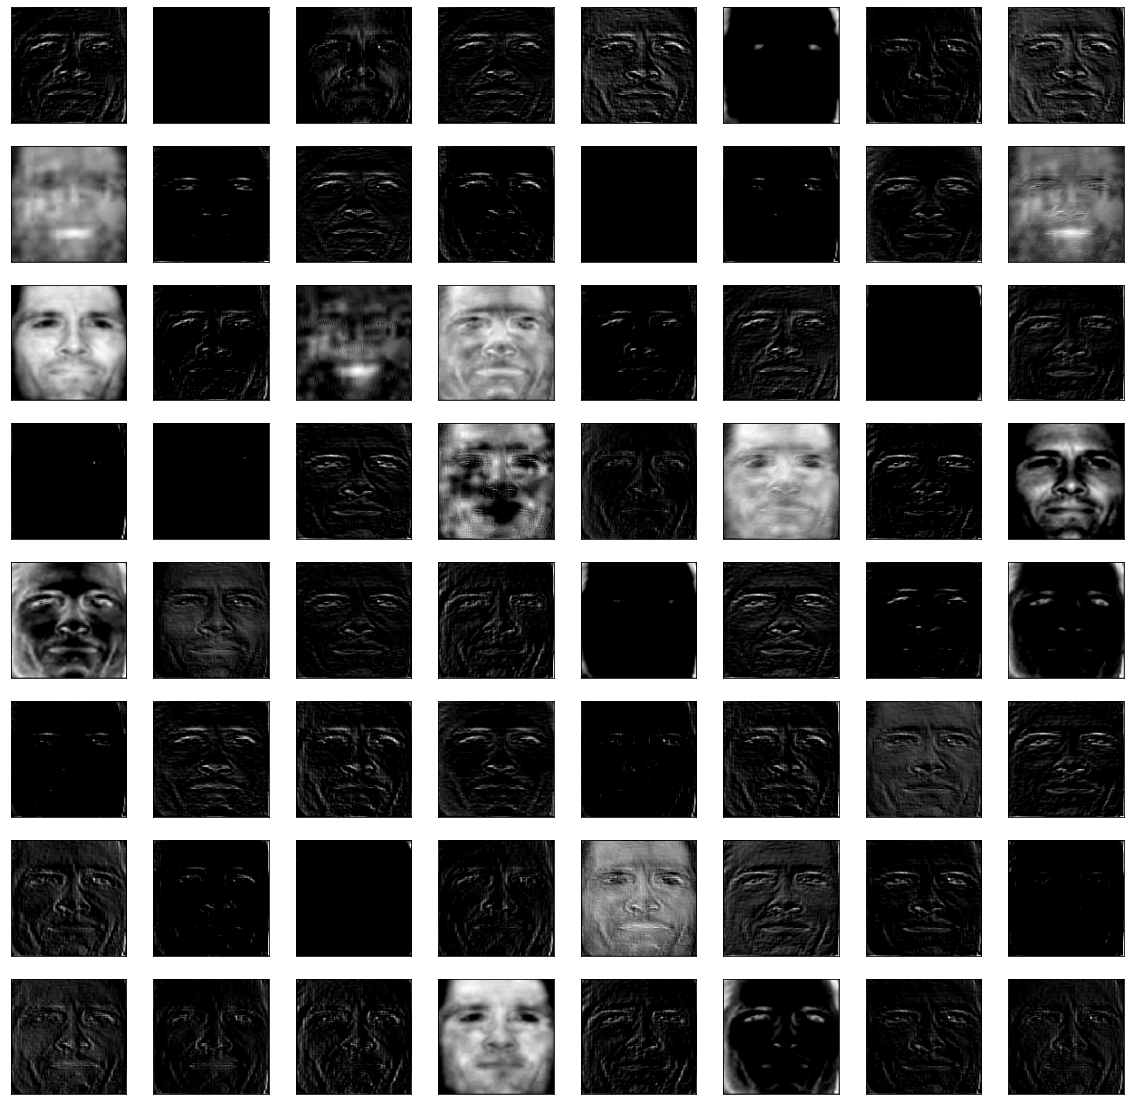

In [92]:
square = 8
ix = 1
plt.figure(figsize=(20,20))

for _ in range(square):
    for _ in range(square):
        
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1

plt.show()